# **CPSC 585 - Artificial Neural Networks**

**Group Project 2, Spring 2023**

Professor: **Kenytt Avery**

**Group 12:**
> * Aneesh Reddy Sannapu
> * Anvit Rajesh Patil
> * Bhavyom Singh Kushwaha
> * Deep Bhikhabhai Madhvani
> * Mann Gawade
> * Sean Hale

# Data Visualization

In [ ]:
import seaborn as sns

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ann2/RateMyProfessor_Sample data.csv")

From the kernel density estimate, we can observe that star rating and difficulty have an inverse relation. For the professors with high star rating, the difficulty us low and professors with low rating the difficulty is high.

<Axes: xlabel='student_star', ylabel='student_difficult'>

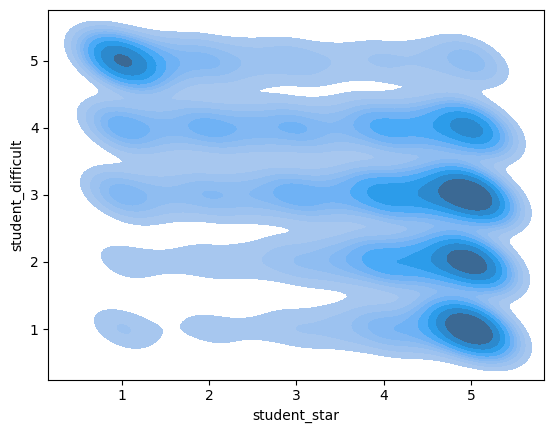

In [ ]:
sns.kdeplot(x = data["student_star"], y = data['student_difficult'],fill=True, common_norm=False)

Count Plot tells us that most students rate their professor 3 or above.

<Axes: xlabel='star_rating', ylabel='count'>

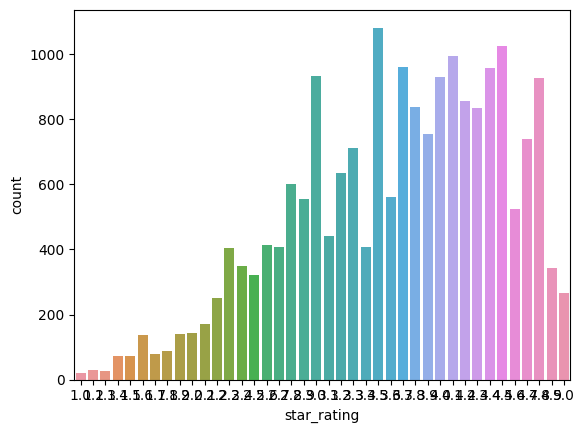

In [ ]:
sns.countplot(x= data['star_rating'])

<ipython-input-33-8b96879b4d02>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr())


<Axes: >

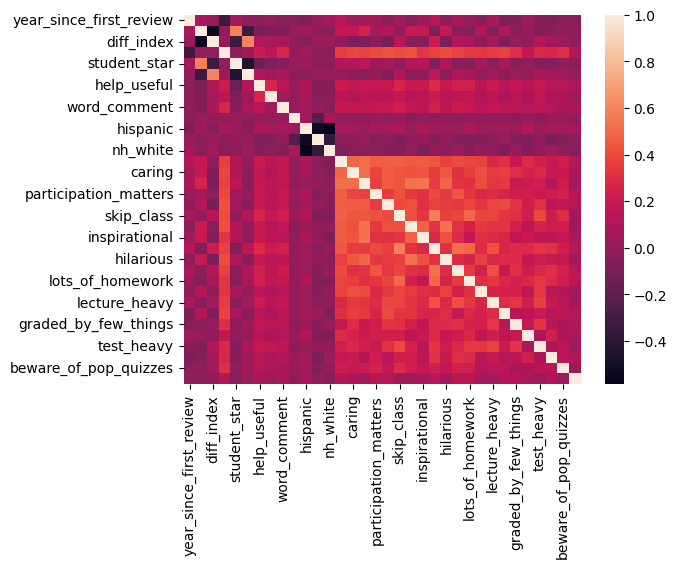

In [ ]:
sns.heatmap(data.corr())

The below graph shows us that if a student got good grades, they are more likely to rate their professor 3.5 or above

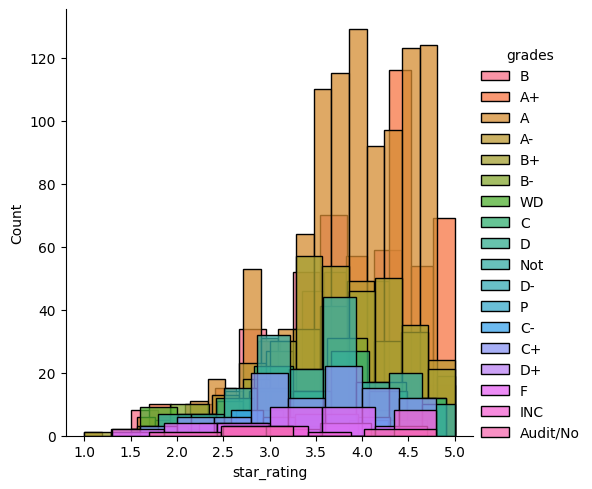

In [ ]:
sns.FacetGrid(data, hue="grades", height = 5).map(sns.histplot, "star_rating").add_legend()

# **Approach 1: Topic Modeling**

**Overview**

*  Prepare the dataset by padding the comments and tokenizing the tokens.

* Using spaCy to eliminate commas and extract phrases with important teacher evaluation and difficulty-related words. With named entity recognition, quick access to word vectors, and extremely quick and accurate syntactic analysis, spaCy is a powerful tool to be use here.

* Building a neural network with Keras to determine whether a comment is connected to teacher evaluation or level of difficulty.

* Analyzing the model's performance using the test data set's correctness.

* We have also used the text-processing.com API which is a simple JSON over HTTP web service for text mining and natural language processing.

**Analyzing**

>We obtain accuracy of **71%** for star rating and **63%** for difficulty over the training data set.

>We used different dataset to test, over the test data set we get accuracy of **62%** for star rating and accuracy of **54%**  for difficulty

Topic modeling is useful when we try to get hidden patterns from text data, which can be beneficial in identifying important aspects of the text data.

The results is sensitive to the choice of hyperparameters, such as the number of topics to be extracted, which might hinder our accuracy.

*We consider tolerance of 1 in testing*








In [ ]:
# We have imported the necessary libraries and downloaded the "en_core_web_lg" model from spaCy
#The model en_core_web_lg is spaCy's biggest English model, measuring 788 MB.

import pandas as pd
import numpy as np
import spacy
import keras
from spacy.lang.en import STOP_WORDS
from spacy.lang.en.stop_words import STOP_WORDS as EN_STOP_WORDS
import spacy.cli
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import seaborn as sns

spacy.cli.download("en_core_web_lg")
nlp = spacy.load("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
#below code reads The Dataset from GoogleDrive

data = pd.read_csv("/content/drive/MyDrive/ann2/RateMyProfessor_Sample data.csv")
print(data.head(5))

   professor_name                                 school_name  \
0  Leslie  Looney  University Of Illinois at Urbana-Champaign   
1  Leslie  Looney  University Of Illinois at Urbana-Champaign   
2  Leslie  Looney  University Of Illinois at Urbana-Champaign   
3  Leslie  Looney  University Of Illinois at Urbana-Champaign   
4  Leslie  Looney  University Of Illinois at Urbana-Champaign   

        department_name                    local_name state_name  \
0  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   
1  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   
2  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   
3  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   
4  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   

   year_since_first_review  star_rating take_again  diff_index  \
0                     11.0          4.7        NaN         2.0   
1                     11.0          4.7        NaN         2.0   
2 

In [ ]:
df = data

In [ ]:
sns.kdeplot(x = data["student_star"], y = data['student_difficult'],fill=True, common_norm=False)

In [ ]:
embeddings_index = {}

#This cell reads in pre-trained word embeddings from a file called "glove.42B.300d.txt" and stores them in a
#dictionary called embeddings_index. The file contains a list of words and their corresponding 300-dimensional vectors
with open('/content/drive/MyDrive/ann2/glove.42B.300d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


In [ ]:

comments_df =df

# In this function list of stopwords are used to ensure that the commonly occuring words in english are removed from the comments.
def get_teacher_rating(comment):

    stop_words = list(STOP_WORDS) + list(EN_STOP_WORDS)
    comment_tokens = [token.text for token in nlp(comment) if token.text not in stop_words]


    rating_sentences = []
    rating_keywords = ["he","she" "excellent", "good", "average", "poor", "terrible", "knowledgeable", "approachable", "helpful", "unhelpful", "responsive", "inspiring", "engaging", "boring", "clear", "confusing", "challenging", "fair", "unfair", "grading", "assessments"]
    for sent in nlp(comment).sents:
        if (any(keyword in sent.text.lower() for keyword in rating_keywords)):
            rating_sentences.append(sent.text)


    rating_summary = ""
    for sentence in rating_sentences:
        sentence_tokens = [token.text for token in nlp(sentence) if token.text not in stop_words]
        if len(set(comment_tokens).intersection(set(sentence_tokens))) > 0:
            rating_summary += sentence.strip() + " "

    return rating_summary

# Similar to the above function for difficulty, a list of stopwords are used to ensure that the commonly occuring words in english are removed from the comments.
def get_teacher_difficulty(comment):

    stop_words = list(STOP_WORDS) + list(EN_STOP_WORDS)
    comment_tokens = [token.text for token in nlp(comment) if token.text not in stop_words]


    difficulty_sentences = []
    dif_keywords = ["challenging", "easy", "hard", "tough", "demanding", "time-consuming", "confusing", "complex", "difficult", "tricky", "intimidating", "daunting", "overwhelming", "strenuous", "arduous"]
    for sent in nlp(comment).sents:
        if (any(keyword in sent.text.lower() for keyword in dif_keywords)):
            difficulty_sentences.append(sent.text)


    difficulty_summary = ""
    for sentence in difficulty_sentences:
        sentence_tokens = [token.text for token in nlp(sentence) if token.text not in stop_words]
        if len(set(comment_tokens).intersection(set(sentence_tokens))) > 0:
            difficulty_summary += sentence.strip() + " "

    return difficulty_summary

# the teacher_rating_summary and teacher_difficulty_summary columns are added to the comments_df.
comments_df['teacher_rating_summary'] = comments_df['comments'].astype(str).apply(get_teacher_rating)
comments_df['teacher_difficulty_summary'] = comments_df['comments'].astype(str).apply(get_teacher_difficulty)

In [ ]:
#for both column star and difficulty we use lamda function , if value is greater then 2.5 then assign 1 and if not assign 0 to corresponding row.
comments_df['student_star'] = df['student_star'].apply(lambda x: 1 if x > 2.5 else 0 )
comments_df['student_difficult'] = df['student_difficult'].apply(lambda x: 1 if x > 2.5 else 0 )

In [ ]:
# Preprocessing the Dataset by tokanizing and padding the comments
tokenizer = Tokenizer()
comments1 = comments_df['teacher_rating_summary'].astype(str).values
tokenizer.fit_on_texts(comments1)
sequences1 = tokenizer.texts_to_sequences(comments1)
max_seq_len1 = max([len(seq) for seq in sequences1])
padded_sequences1 = pad_sequences(sequences1, maxlen=max_seq_len1, padding='post')

comments = comments_df['teacher_difficulty_summary'].astype(str).values
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)
max_seq_len = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_seq_len, padding='post')


#  network architecture using Keras
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model_rating = keras.Sequential([
    keras.layers.Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=128, trainable=False),
    keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(1, activation='linear')
])

model_difficulty = keras.Sequential([
    keras.layers.Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=73, trainable=False),
    keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(1, activation='linear')
])

model_rating.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_difficulty.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
from keras.models import load_model

print("Model Summary for Student Star")
model1.summary()

print()
print("Model Summary for Student Difficulty")
model.summary()

Model Summary for Student Star
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 128, 300)          4320300   
                                                                 
 lstm_4 (LSTM)               (None, 64)                93440     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,413,805
Trainable params: 93,505
Non-trainable params: 4,320,300
_________________________________________________________________

Model Summary for Student Difficulty
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 73, 300)           4320300   
              

In [ ]:
model_rating.fit(padded_sequences1, np.array(comments_df['student_star']), epochs=5, batch_size=100)
model_difficulty.fit(padded_sequences, np.array(comments_df['student_difficult']), epochs=5, batch_size=100)

Epoch 1/5
200/200 [==============================] - 47s 219ms/step - loss: 0.9429 - accuracy: 0.5366
Epoch 2/5
200/200 [==============================] - 46s 227ms/step - loss: 0.6042 - accuracy: 0.7156
Epoch 3/5
200/200 [==============================] - 44s 222ms/step - loss: 0.6023 - accuracy: 0.7160
Epoch 4/5
200/200 [==============================] - 44s 220ms/step - loss: 0.6015 - accuracy: 0.7160
Epoch 5/5
200/200 [==============================] - 46s 228ms/step - loss: 0.6000 - accuracy: 0.7161
Epoch 1/5
200/200 [==============================] - 28s 123ms/step - loss: 0.8522 - accuracy: 0.5822
Epoch 2/5
200/200 [==============================] - 25s 126ms/step - loss: 0.6604 - accuracy: 0.6359
Epoch 3/5
200/200 [==============================] - 25s 125ms/step - loss: 0.6655 - accuracy: 0.6303
Epoch 4/5
200/200 [==============================] - 25s 126ms/step - loss: 0.6607 - accuracy: 0.6359
Epoch 5/5
200/200 [==============================] - 24s 121ms/step - loss: 0.6605

**Both the models are trainned and model_rating have achived the accuracy of 0.7161 and model_difficulty has achived an accuracy of 0.6356. We Save the models in the next step.**

In [ ]:
model_rating.save('/content/drive/MyDrive/ann2/models/rating_model_topicmod.h5')
model_difficulty.save('/content/drive/MyDrive/ann2/models/diff_model_topicmod.h5')

**TESTING ON NEW DATA**

In [ ]:
import json
import pandas as pd


with open('/content/drive/MyDrive/ann2/all_reviews.json', 'r') as f:
    data = json.load(f)

# Extract relevant columns
df = pd.DataFrame(columns=['Quality', 'Difficulty', 'Comment'])
for entry in data:
    for item in entry:
        df = df.append({
            'Quality': item['Quality'],
            'Difficulty': item['Difficulty'],
            'Comment': item['Comment']
        }, ignore_index=True)



Streaming output truncated to the last 5000 lines.
<ipython-input-116-6c5fd038c047>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-116-6c5fd038c047>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-116-6c5fd038c047>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-116-6c5fd038c047>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-116-6c5fd038c047>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipy

In [ ]:
test_data =df

In [ ]:
test_data

,Quality,Difficulty,Comment
0,5.0,2.0,Professor Nichols is super nice and very whole...
1,3.0,1.0,"Very chill class and teacher, very easy grader..."
2,4.0,1.0,"Awesome, easy, knows literally everything abou..."
3,5.0,2.0,Prof. Nichols is a super nice and encouraging ...
4,5.0,1.0,Good Professor. Really nice and encouraging te...
...,...,...,...
3369,1.0,4.0,don't take this call unless you love memorizin...
3370,4.0,2.0,Really funny guy. He gives ridiculous (but app...
3371,2.5,4.0,Only teaches from powerpoints and gives tons o...
3372,4.5,2.0,Awesome prof. Gives out homework and short ess...


In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split


max_seq_len = 128
model = load_model('/content/drive/MyDrive/ann2/models/rating_model_topicmod.h5')

# Define the API endpoint
url = "http://text-processing.com/api/sentiment/"


df = test_data[0:100]


def calculate_score(comment):

    response = requests.post(url, data={'text': comment})

    sentiment_score = response.json()['probability']['pos']
    # Use TexBlob to get the sentiment polarity
    polarity = TextBlob(comment).sentiment.polarity

    comment_seq = tokenizer.texts_to_sequences([comment])
    comment_seq = pad_sequences(comment_seq, maxlen=max_seq_len, padding='post')

    score = model.predict(comment_seq)[0][0]
    score = (score*4)+1
    # Calculate the final score based on polarity and sentiment
    if polarity > .15:
        if sentiment_score < .4:
            score1 = (score + ((abs(polarity)) * 1.8) - 1)
        elif sentiment_score > .4:
            score1 = (score + ((abs(polarity)) * 1.8) +1)
    elif polarity <.15:
        if sentiment_score < .4:
            score1 = (score - ((abs(polarity)) * 1.8) - 1)
        elif sentiment_score > .4:
            score1 = (score - ((abs(polarity)) * 1.8) +1)
    if score1 > 5:
        score1 = 5
    elif score1<1:
        score1 = 1
    return np.round(score1*2)/2


df['Final Score'] = df['Comment'].apply(calculate_score)


1/1 [==============================] - 0s 57ms/step


<ipython-input-120-e03d79d90d16>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Final Score'] = df['Comment'].apply(calculate_score)


In [ ]:
df

,Quality,Difficulty,Comment,Final Score
0,5.0,2.0,Professor Nichols is super nice and very whole...,5.0
1,3.0,1.0,"Very chill class and teacher, very easy grader...",5.0
2,4.0,1.0,"Awesome, easy, knows literally everything abou...",4.5
3,5.0,2.0,Prof. Nichols is a super nice and encouraging ...,5.0
4,5.0,1.0,Good Professor. Really nice and encouraging te...,5.0
...,...,...,...,...
95,3.5,1.0,Professor Martin is a very sweet man who knows...,5.0
96,5.0,2.0,FHS:Opera/Ballet.Signed up for it simply for t...,4.5
97,4.0,1.0,Super laid-back gov 20 class. Took as a GE bec...,5.0
98,3.0,1.0,I was someone that took gov in high school and...,4.5


In [ ]:
df1 = np.array(df['Final Score'])
df1

array([5. , 5. , 4.5, 5. , 5. , 3. , 4.5, 5. , 5. , 5. , 5. , 5. , 3.5,
       5. , 3.5, 5. , 3. , 4.5, 5. , 5. , 2.5, 4.5, 5. , 3. , 3.5, 5. ,
       5. , 5. , 5. , 2.5, 5. , 5. , 5. , 3. , 5. , 5. , 4.5, 5. , 1. ,
       5. , 5. , 5. , 2.5, 2.5, 4. , 3. , 2. , 5. , 4.5, 2.5, 4.5, 2.5,
       5. , 3.5, 5. , 2. , 2.5, 3.5, 1.5, 4.5, 3. , 2.5, 2.5, 5. , 5. ,
       4.5, 5. , 5. , 1. , 5. , 4.5, 2. , 5. , 5. , 5. , 5. , 4.5, 5. ,
       4.5, 2.5, 4.5, 2.5, 1.5, 5. , 3.5, 5. , 5. , 4.5, 2. , 5. , 5. ,
       3. , 2.5, 4.5, 5. , 5. , 4.5, 5. , 4.5, 5. ])

In [ ]:
df2 = np.array(df['Quality'])
df2 =  df2.astype(float)
df2

array([5. , 3. , 4. , 5. , 5. , 4.5, 4. , 3.5, 4. , 5. , 5. , 5. , 4. ,
       4.5, 3.5, 1. , 4. , 4. , 4.5, 3.5, 4. , 4. , 1. , 2.5, 3. , 5. ,
       4. , 3. , 4.5, 3. , 5. , 2.5, 5. , 5. , 4. , 5. , 5. , 3.5, 1. ,
       3. , 4. , 5. , 4. , 1. , 2.5, 3. , 1.5, 4.5, 1. , 1.5, 4. , 2. ,
       2.5, 3. , 4. , 1. , 1. , 1.5, 1. , 1. , 1. , 2.5, 2. , 2. , 4. ,
       4. , 2. , 2. , 1. , 4.5, 5. , 1.5, 2.5, 4. , 4. , 4.5, 4. , 2. ,
       1.5, 1.5, 5. , 4.5, 2. , 1. , 3.5, 2. , 1.5, 2.5, 1. , 5. , 3. ,
       4.5, 4. , 4. , 3. , 3.5, 5. , 4. , 3. , 4.5])

In [ ]:


within_tolerance = np.abs(df1 - df2) <= tolerance


accuracy = np.mean(within_tolerance) * 100

print("Accuracy percentage for rating with MSE of", tolerance, "is:", accuracy, "%")

Accuracy percentage for rating with MSE of 1 is: 62.0 %


In [ ]:
max_seq_len = 78
model = load_model('/content/drive/MyDrive/ann2/models/diff_model_topicmod.h5')

# Define the API endpoint
url = "http://text-processing.com/api/sentiment/"


df = test_data[0:100]


def calculate_score(comment):

    response = requests.post(url, data={'text': comment})

    sentiment_score = response.json()['probability']['pos']
    # Use TexBlob to get the sentiment polarity
    polarity = TextBlob(comment).sentiment.polarity

    comment_seq = tokenizer.texts_to_sequences([comment])
    comment_seq = pad_sequences(comment_seq, maxlen=max_seq_len, padding='post')

    score = model.predict(comment_seq)[0][0]
    score = (score*4)+1
    # Calculate the final score based on polarity and sentiment
    if polarity > .15:
        if sentiment_score < .4:
            score1 = (score + ((abs(polarity)) * 1.8) - 1)
        elif sentiment_score > .4:
            score1 = (score + ((abs(polarity)) * 1.8) +1)
    elif polarity <.15:
        if sentiment_score < .4:
            score1 = (score - ((abs(polarity)) * 1.8) - 1)
        elif sentiment_score > .4:
            score1 = (score - ((abs(polarity)) * 1.8) +1)
    if score1 > 5:
        score1 = 5
    elif score1<1:
        score1 = 1
    return np.round(score1*2)/2


df['Final Score diff'] = df['Comment'].apply(calculate_score)


1/1 [==============================] - 0s 46ms/step


<ipython-input-129-44bd3d6e4df7>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Final Score diff'] = df['Comment'].apply(calculate_score)


In [ ]:
df1 = np.array(df['Final Score diff'])
df2 = np.array(df['Difficulty'])
df2 =  df2.astype(float)

In [ ]:

within_tolerance = np.abs(df1 - df2) <= tolerance


accuracy = np.mean(within_tolerance) * 100

print("Accuracy percentage for dif with MSE of", tolerance, "is:", accuracy, "%")

Accuracy percentage for dif with MSE of 1 is: 54.0 %


# **Appraoch 2: Sentiment Intensity Analysis, Version 1**

**Overview**

A model for text sentiment analysis called VADER (Valence Aware Dictionary for Sentiment Reasoning) is sensitive to both the polarity (positive/negative) and intensity (strong) of emotion. It may be used right away on unlabeled text data and is included in the NLTK package.

**Analyzing**

Star Rating
>**Training data Mean Squared Error** : **1.16**

> **Test data Accuracy** : **63%**.

Difficulty Rating
>**Training data Mean Squared Error**: **1.48**

>**Test data Accuracy** : **65%**.

This model considers both polarity and intensity of emotions, which provides more nuanced results.

We haven't perform any hyperparameter tuning for this model

*We consider tolerance of 1 in testing*





In [ ]:
## Adding necessary imports
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN


In [ ]:
## Loading dataset
data = pd.read_csv("/content/drive/MyDrive/ann2/RateMyProfessor_Sample data.csv")
## Displaying top 5 rows
data.head(5)

   professor_name                                 school_name  \
0  Leslie  Looney  University Of Illinois at Urbana-Champaign   
1  Leslie  Looney  University Of Illinois at Urbana-Champaign   
2  Leslie  Looney  University Of Illinois at Urbana-Champaign   
3  Leslie  Looney  University Of Illinois at Urbana-Champaign   
4  Leslie  Looney  University Of Illinois at Urbana-Champaign   

        department_name                    local_name state_name  \
0  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   
1  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   
2  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   
3  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   
4  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   

   year_since_first_review  star_rating take_again  diff_index  \
0                     11.0          4.7        NaN         2.0   
1                     11.0          4.7        NaN         2.0   
2 

In [ ]:
df = data

We have used Sentiment Intensity Analyzer to get different polarity scores(such as polarity, positive score, negative score, neutral score) for the comments from our dataset.

In [ ]:
## Downloading VADER Lexicon and initailizing Sentiment Intensity Analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def get_sentiment_scores(comment):
    sentiment_scores = sia.polarity_scores(comment)
    return sentiment_scores['compound'], sentiment_scores['pos'], sentiment_scores['neg'], sentiment_scores['neu']

In [ ]:
df['polarity'], df['pos_score'], df['neg_score'], df['neu_score'] = zip(*df['comments'].astype(str).apply(get_sentiment_scores))

Rearranging the column to create a single dataframe and then splitting them into X and Y values, also dropping NA values

In [ ]:


X = np.array(df[['polarity', 'pos_score', 'neg_score', 'neu_score']])
y = np.array(df['student_star'])


In [ ]:
df[['polarity', 'pos_score', 'neg_score', 'neu_score','student_star']]

,polarity,pos_score,neg_score,neu_score,student_star
0,0.9488,0.293,0.022,0.685,5.0
1,0.9476,0.340,0.000,0.660,5.0
2,0.9325,0.415,0.053,0.531,4.0
3,0.9655,0.281,0.035,0.684,5.0
4,0.9870,0.426,0.026,0.549,5.0
...,...,...,...,...,...
19995,0.8877,0.654,0.000,0.346,1.5
19996,-0.1962,0.082,0.095,0.823,2.5
19997,0.9378,0.428,0.000,0.572,5.0
19998,0.8750,0.478,0.000,0.522,4.0


In [ ]:
k = df[['polarity', 'pos_score', 'neg_score', 'neu_score','student_star']]

In [ ]:
k = k.dropna()
X = k[['polarity', 'pos_score', 'neg_score', 'neu_score']]
y = k['student_star']

> Here, we are scaling the values and defining the architechture of our model. We have used a Sequential model with two LSTM layers and a Dense layer.

> The first LSTM layer has 64 units and ReLU as the activation function. The second LSTM is similar with 32 units and ReLU as the activation function. We have added a Dropout layer as well in between the two LSTM layers. We also have a Dense layer with linear activation function.

>On evaluating the model, we are getting a **Mean Squared Error** as **1.1682180166244507**

In [ ]:

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# architecture of the LSTM
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, epochs=10, batch_size=32)


mse = model.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test)
print("Mean Squared Error:", mse)

Epoch 1/10
500/500 [==============================] - 17s 26ms/step - loss: 2.5529
Epoch 2/10
500/500 [==============================] - 12s 24ms/step - loss: 1.2918
Epoch 3/10
500/500 [==============================] - 11s 23ms/step - loss: 1.2682
Epoch 4/10
500/500 [==============================] - 13s 26ms/step - loss: 1.2623
Epoch 5/10
500/500 [==============================] - 13s 26ms/step - loss: 1.2501
Epoch 6/10
500/500 [==============================] - 14s 27ms/step - loss: 1.2427
Epoch 7/10
500/500 [==============================] - 15s 29ms/step - loss: 1.2394
Epoch 8/10
500/500 [==============================] - 13s 26ms/step - loss: 1.2396
Epoch 9/10
500/500 [==============================] - 13s 25ms/step - loss: 1.2345
Epoch 10/10
125/125 [==============================] - 1s 4ms/step - loss: 1.1682
Mean Squared Error: 1.1682180166244507


In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 4, 64)             16896     
                                                                 
 dropout_1 (Dropout)         (None, 4, 64)             0         
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.save('/content/drive/MyDrive/ann2/models/senti_rating.h5')

Now, we are trying to predict and check the accuracy of our model for **Student Star Rating** on the all_reviews.json.

 > Testing MSE : 1.1682180166244507

 > Testing accuracy : 67%



Here, we are loading the testing dataset and extracting columns like Quality, Difficulty and Comment.

In [ ]:
import json
import pandas as pd


with open('/content/drive/MyDrive/ann2/all_reviews.json', 'r') as f:
    data = json.load(f)

# Extract relevant columns
df = pd.DataFrame(columns=['Quality', 'Difficulty', 'Comment'])
for entry in data:
    for item in entry:
        df = df.append({
            'Quality': item['Quality'],
            'Difficulty': item['Difficulty'],
            'Comment': item['Comment']
        }, ignore_index=True)

test_data = df

Streaming output truncated to the last 5000 lines.
<ipython-input-210-65629adaf2a9>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-210-65629adaf2a9>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-210-65629adaf2a9>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-210-65629adaf2a9>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-210-65629adaf2a9>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipy

In [ ]:
test_data

,Quality,Difficulty,Comment
0,5.0,2.0,Professor Nichols is super nice and very whole...
1,3.0,1.0,"Very chill class and teacher, very easy grader..."
2,4.0,1.0,"Awesome, easy, knows literally everything abou..."
3,5.0,2.0,Prof. Nichols is a super nice and encouraging ...
4,5.0,1.0,Good Professor. Really nice and encouraging te...
...,...,...,...
3369,1.0,4.0,don't take this call unless you love memorizin...
3370,4.0,2.0,Really funny guy. He gives ridiculous (but app...
3371,2.5,4.0,Only teaches from powerpoints and gives tons o...
3372,4.5,2.0,Awesome prof. Gives out homework and short ess...


In [ ]:
df = test_data[0:100]

In [ ]:
df

,Quality,Difficulty,Comment
0,5.0,2.0,Professor Nichols is super nice and very whole...
1,3.0,1.0,"Very chill class and teacher, very easy grader..."
2,4.0,1.0,"Awesome, easy, knows literally everything abou..."
3,5.0,2.0,Prof. Nichols is a super nice and encouraging ...
4,5.0,1.0,Good Professor. Really nice and encouraging te...
...,...,...,...
95,3.5,1.0,Professor Martin is a very sweet man who knows...
96,5.0,2.0,FHS:Opera/Ballet.Signed up for it simply for t...
97,4.0,1.0,Super laid-back gov 20 class. Took as a GE bec...
98,3.0,1.0,I was someone that took gov in high school and...


Here, we have defined the predict function that uses polarities and saved model.

In [ ]:
import numpy as np
import pandas as pd
import requests
from keras.models import load_model

def predict_the(df):
    max_seq_len = 78
    model = load_model('/content/drive/MyDrive/ann2/models/senti_rating.h5')

    scores = []
    for comment in df['Comment']:


        #  sentiment scores
        sentiment_scores = sia.polarity_scores(comment)
        polarity_vader = sentiment_scores['compound']
        pos_score = sentiment_scores['pos']
        neg_score = sentiment_scores['neg']
        neu_score = sentiment_scores['neu']

        # Prepare the comment data for input to the model
        new_comment = np.array([polarity, pos_score, neg_score, neu_score]).reshape((1, 4, 1))

        # Make the prediction using the model
        prediction = model.predict(new_comment)
        score = prediction[0][0]



        # Round the score to the nearest half point
        k = (np.round(score * 2) / 2)
        scores.append(k)

    # Add the predicted scores as a new column in the dataframe
    df['predicted_score'] = scores

    return df

In [ ]:
df = predict_the(df)

1/1 [==============================] - 0s 24ms/step


<ipython-input-214-c7697ebc8e90>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_score'] = scores


In [ ]:
df1 = np.array(df['predicted_score'])
df2 = np.array(df['Quality'])
df2 =  df2.astype(float)


within_tolerance = np.abs(df1 - df2) <= tolerance
accuracy = np.mean(within_tolerance) * 100
print("Accuracy percentage for star rating with MSE of", tolerance, "is:", accuracy, "%")

Accuracy percentage for star rating with MSE of 1.1682180166244507 is: 67.0 %


Now, we will apply similar approach for Student Difficulty Rating

In [ ]:
k = df[['polarity', 'pos_score', 'neg_score', 'neu_score','student_difficult']]

In [ ]:
k = k.dropna()
X = k[['polarity', 'pos_score', 'neg_score', 'neu_score']]
y = k['student_difficult']

We are performing the following steps:
> Scaling input X

> Splitting Dataset

> Training Model

> Evaluating model for MSE on training data

**For Difficulty Rating, MSE** : **1.50236177444458**

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# architecture of the LSTM
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, epochs=10, batch_size=32)


mse = model.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test)
print("Mean Squared Error:", mse)

Epoch 1/10
500/500 [==============================] - 20s 30ms/step - loss: 2.3356
Epoch 2/10
500/500 [==============================] - 11s 23ms/step - loss: 1.5382
Epoch 3/10
500/500 [==============================] - 12s 25ms/step - loss: 1.5298
Epoch 4/10
500/500 [==============================] - 13s 26ms/step - loss: 1.5182
Epoch 5/10
500/500 [==============================] - 13s 26ms/step - loss: 1.5222
Epoch 6/10
500/500 [==============================] - 13s 26ms/step - loss: 1.5199
Epoch 7/10
500/500 [==============================] - 13s 26ms/step - loss: 1.5155
Epoch 8/10
500/500 [==============================] - 13s 26ms/step - loss: 1.5103
Epoch 9/10
500/500 [==============================] - 13s 27ms/step - loss: 1.5116
Epoch 10/10
125/125 [==============================] - 1s 4ms/step - loss: 1.5024
Mean Squared Error: 1.50236177444458


In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 4, 64)             16896     
                                                                 
 dropout_3 (Dropout)         (None, 4, 64)             0         
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## Saving the difficulty model
model.save('/content/drive/MyDrive/ann2/models/senti_diff.h5')

Now we are predicting and evaluating the accuracy on test data.
> To do that, we have loaded the test data and extracted relevant columns such as Quality, Difficulty and Comments.

In [ ]:
import json
import pandas as pd


with open('/content/drive/MyDrive/ann2/all_reviews.json', 'r') as f:
    data = json.load(f)

# Extract relevant columns
df = pd.DataFrame(columns=['Quality', 'Difficulty', 'Comment'])
for entry in data:
    for item in entry:
        df = df.append({
            'Quality': item['Quality'],
            'Difficulty': item['Difficulty'],
            'Comment': item['Comment']
        }, ignore_index=True)

test_data = df

Streaming output truncated to the last 5000 lines.
<ipython-input-2-65629adaf2a9>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-2-65629adaf2a9>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-2-65629adaf2a9>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-2-65629adaf2a9>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-2-65629adaf2a9>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input

In [ ]:
df = test_data[0:100]

In [ ]:
df

,Quality,Difficulty,Comment
0,5.0,2.0,Professor Nichols is super nice and very whole...
1,3.0,1.0,"Very chill class and teacher, very easy grader..."
2,4.0,1.0,"Awesome, easy, knows literally everything abou..."
3,5.0,2.0,Prof. Nichols is a super nice and encouraging ...
4,5.0,1.0,Good Professor. Really nice and encouraging te...
...,...,...,...
95,3.5,1.0,Professor Martin is a very sweet man who knows...
96,5.0,2.0,FHS:Opera/Ballet.Signed up for it simply for t...
97,4.0,1.0,Super laid-back gov 20 class. Took as a GE bec...
98,3.0,1.0,I was someone that took gov in high school and...


> Here we have defined a predict function that used model and polarities to predict.

Difficulty Rating
> **Testing Accuracy** : **65%**

In [ ]:
import numpy as np
import pandas as pd
import requests

from keras.models import load_model

def predict_the_dif(df):
    max_seq_len = 78
    model = load_model('/content/drive/MyDrive/ann2/models/senti_diff.h5')

    scores = []
    for comment in df['Comment']:


        # Use VADER to get the sentiment scores
        sentiment_scores = sia.polarity_scores(comment)
        polarity_vader = sentiment_scores['compound']
        pos_score = sentiment_scores['pos']
        neg_score = sentiment_scores['neg']
        neu_score = sentiment_scores['neu']

        # Prepare the comment data for input to the model
        new_comment = np.array([polarity_vader, pos_score, neg_score, neu_score]).reshape((1, 4, 1))

        # Make the prediction using the model
        prediction = model.predict(new_comment)
        score = prediction[0][0]

        # Apply rules to adjust the score based on sentiment and polarity

        if score > 5:
            score = 5
        elif score < 1:
            score = 1


        # Round the score to the nearest half point
        k = (np.round(score * 2) / 2)
        scores.append(k)

    # Add the predicted scores as a new column in the dataframe
    df['predicted_score'] = scores

    return df

In [ ]:
df = predict_the_dif(df)

1/1 [==============================] - 0s 23ms/step


<ipython-input-10-dfdb35f1d0e4>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_score'] = scores


In [ ]:
df

,Quality,Difficulty,Comment,predicted_score
0,5.0,2.0,Professor Nichols is super nice and very whole...,2.5
1,3.0,1.0,"Very chill class and teacher, very easy grader...",3.0
2,4.0,1.0,"Awesome, easy, knows literally everything abou...",3.0
3,5.0,2.0,Prof. Nichols is a super nice and encouraging ...,2.5
4,5.0,1.0,Good Professor. Really nice and encouraging te...,2.5
...,...,...,...,...
95,3.5,1.0,Professor Martin is a very sweet man who knows...,2.5
96,5.0,2.0,FHS:Opera/Ballet.Signed up for it simply for t...,2.5
97,4.0,1.0,Super laid-back gov 20 class. Took as a GE bec...,2.5
98,3.0,1.0,I was someone that took gov in high school and...,3.0


In [ ]:
df1 = np.array(df['predicted_score'])
df2 = np.array(df['Difficulty'])
df2 =  df2.astype(float)

within_tolerance = np.abs(df1 - df2) <= tolerance
accuracy = np.mean(within_tolerance) * 100
print("Accuracy percentage for star difficulty is:", accuracy, "%")

Accuracy percentage for star difficulty is: 65.0 %


# **Approach 3: Sentiment Intensity Analysis, Version 2**





**Overview**

In this version, we are doing test cleaning aggressively to evaluate if we get a better accuracy.
> We are removing punctuation and stopwords in addition to dropping NA fields.

> Code is similar to the last approach

> There is a significant in accuracy for Difficulty Rating and Star Rating accuracy also improved. We can see the impact of cleaning data. The loss increased, slightly.

**Analysis**

Star Rating
> Traning MSE : 1.299601435661316

> Testing MSE : 1.2041118144989014

> Testing Accuracy : 65%

Difficulty Rating
> Traning MSE : 1.5125211477279663

> Testing MSE : 1.5

> Testing Accuracy : 73%



*We consider tolerance of 1 in testing*

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/ann2/RateMyProfessor_Sample data.csv")
data.head(5)

   professor_name                                 school_name  \
0  Leslie  Looney  University Of Illinois at Urbana-Champaign   
1  Leslie  Looney  University Of Illinois at Urbana-Champaign   
2  Leslie  Looney  University Of Illinois at Urbana-Champaign   
3  Leslie  Looney  University Of Illinois at Urbana-Champaign   
4  Leslie  Looney  University Of Illinois at Urbana-Champaign   

        department_name                    local_name state_name  \
0  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   
1  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   
2  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   
3  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   
4  Astronomy department   Champaign\xe2\x80\x93Urbana         IL   

   year_since_first_review  star_rating take_again  diff_index  \
0                     11.0          4.7        NaN         2.0   
1                     11.0          4.7        NaN         2.0   
2 

In [ ]:
df = data

Removing punctuations from dataframe

In [ ]:
df['comments'] = df['comments'].str.lower()
import string
import re

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_punctuation_extra(text):
    text = re.sub('[—-]', ' ', text)
    text = re.sub('[”“]', '', text)
    return text

df['comments'] = df['comments'].astype(str).apply(remove_punctuation_extra)
df['comments'] = df['comments'].astype(str).apply(remove_punctuation)




Downloading and Removing stopwords from dataframe

In [ ]:
import nltk
nltk.download('stopwords')
def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('english')
    removed = [i for i in text.split() if i not in stopwords]
    return removed

df['comments'] = df['comments'].apply(remove_stopwords)
df['comments'] = df['comments'].str.join(' ')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In this step, we have performed the following for **Star Rating**,
>using VADER lexicon and Sentiment Intensity Analyser to get polarity scores

>dropping NA fields, and arranging the fields to get X and Y datasets.

>Splitting the data, creating model and training the model

>Evaluating the model for Mean Squared Error and finally saving the model

**Mean Squared Error : 1.299601435661316**

In [ ]:

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(comment):
    sentiment_scores = sia.polarity_scores(comment)
    return sentiment_scores['compound'], sentiment_scores['pos'], sentiment_scores['neg'], sentiment_scores['neu']


df['polarity'], df['pos_score'], df['neg_score'], df['neu_score'] = zip(*df['comments'].astype(str).apply(get_sentiment_scores))




X = np.array(df[['polarity', 'pos_score', 'neg_score', 'neu_score']])
y = np.array(df['student_star'])


df[['polarity', 'pos_score', 'neg_score', 'neu_score','student_star']]


k = df[['polarity', 'pos_score', 'neg_score', 'neu_score','student_star']]


k = k.dropna()
X = k[['polarity', 'pos_score', 'neg_score', 'neu_score']]
y = k['student_star']


scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# architecture of the LSTM
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, epochs=10, batch_size=32)


mse = model.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test)
print("Mean Squared Error:", mse)


model.save('/content/drive/MyDrive/ann2/models/senti_rating_filter.h5')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Epoch 1/10
500/500 [==============================] - 16s 26ms/step - loss: 2.6983
Epoch 2/10
500/500 [==============================] - 13s 26ms/step - loss: 1.3718
Epoch 3/10
500/500 [==============================] - 13s 26ms/step - loss: 1.3473
Epoch 4/10
500/500 [==============================] - 13s 26ms/step - loss: 1.3370
Epoch 5/10
500/500 [==============================] - 15s 30ms/step - loss: 1.3281
Epoch 6/10
500/500 [==============================] - 13s 26ms/step - loss: 1.3219
Epoch 7/10
500/500 [==============================] - 13s 26ms/step - loss: 1.3177
Epoch 8/10
500/500 [==============================] - 13s 26ms/step - loss: 1.3122
Epoch 9/10
500/500 [==============================] - 13s 26ms/step - loss: 1.3115
Epoch 10/10
125/125 [==============================] - 1s 4ms/step - loss: 1.2996
Mean Squared Error: 1.299601435661316


In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 4, 64)             16896     
                                                                 
 dropout_6 (Dropout)         (None, 4, 64)             0         
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In this step, we have performed the following for **Difficulty Rating**,
>using VADER lexicon and Sentiment Intensity Analyser to get polarity scores

>dropping NA fields, and arranging the fields to get X and Y datasets.

>Splitting the data, creating model and training the model

>Evaluating the model for Mean Squared Error and finally saving the model

**Mean Squared Error : 1.5125211477279663**

In [ ]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def get_sentiment_scores(comment):
    sentiment_scores = sia.polarity_scores(comment)
    return sentiment_scores['compound'], sentiment_scores['pos'], sentiment_scores['neg'], sentiment_scores['neu']


df['polarity'], df['pos_score'], df['neg_score'], df['neu_score'] = zip(*df['comments'].astype(str).apply(get_sentiment_scores))



k = df[['polarity', 'pos_score', 'neg_score', 'neu_score','student_difficult']]

k = k.dropna()
X = k[['polarity', 'pos_score', 'neg_score', 'neu_score']]
y = k['student_difficult']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# architecture of the LSTM
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], 1), activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, activation='relu'))
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')


model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train, epochs=10, batch_size=32)


mse = model.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test)
print("Mean Squared Error:", mse)

model.save('/content/drive/MyDrive/ann2/models/senti_diff_filter.h5')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Epoch 1/10
500/500 [==============================] - 17s 26ms/step - loss: 2.3996
Epoch 2/10
500/500 [==============================] - 12s 23ms/step - loss: 1.5685
Epoch 3/10
500/500 [==============================] - 12s 24ms/step - loss: 1.5655
Epoch 4/10
500/500 [==============================] - 13s 26ms/step - loss: 1.5558
Epoch 5/10
500/500 [==============================] - 13s 26ms/step - loss: 1.5496
Epoch 6/10
500/500 [==============================] - 15s 31ms/step - loss: 1.5453
Epoch 7/10
500/500 [==============================] - 13s 26ms/step - loss: 1.5440
Epoch 8/10
500/500 [==============================] - 13s 26ms/step - loss: 1.5385
Epoch 9/10
500/500 [==============================] - 13s 26ms/step - loss: 1.5364
Epoch 10/10
125/125 [==============================] - 1s 4ms/step - loss: 1.5125
Mean Squared Error: 1.5125211477279663


In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 4, 64)             16896     
                                                                 
 dropout_7 (Dropout)         (None, 4, 64)             0         
                                                                 
 lstm_21 (LSTM)              (None, 32)                12416     
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In this step, we are performing the following for **Star Rating**,

> Loading the testing dataset and extracting the useful columns such as Quality, Difficulty and Comment

>Creating a prediction function that uses prolarity scores and saved model for prediction and accuracy.

**Star Rating :**

>MSE : 1.2041118144989014

>Accuracy : 65%

In [ ]:
import json
import pandas as pd


with open('/content/drive/MyDrive/ann2/all_reviews.json', 'r') as f:
    data = json.load(f)

# Extract relevant columns
df = pd.DataFrame(columns=['Quality', 'Difficulty', 'Comment'])
for entry in data:
    for item in entry:
        df = df.append({
            'Quality': item['Quality'],
            'Difficulty': item['Difficulty'],
            'Comment': item['Comment']
        }, ignore_index=True)

test_data = df


df = test_data[0:100]


import numpy as np

import requests
from keras.models import load_model

def predict_the(df):
    max_seq_len = 78
    model = load_model('/content/drive/MyDrive/ann2/models/senti_rating_filter.h5')

    scores = []
    for comment in df['Comment']:


        #  sentiment scores
        sentiment_scores = sia.polarity_scores(comment)
        polarity_vader = sentiment_scores['compound']
        pos_score = sentiment_scores['pos']
        neg_score = sentiment_scores['neg']
        neu_score = sentiment_scores['neu']

        # Prepare the comment data for input to the model
        new_comment = np.array([polarity, pos_score, neg_score, neu_score]).reshape((1, 4, 1))

        # Make the prediction using the model
        prediction = model.predict(new_comment)
        score = prediction[0][0]



        # Round the score to the nearest half point
        k = (np.round(score * 2) / 2)
        scores.append(k)

    # Add the predicted scores as a new column in the dataframe
    df['predicted_score'] = scores

    return df


df = predict_the(df)


df1 = np.array(df['predicted_score'])
df2 = np.array(df['Quality'])
df2 =  df2.astype(float)



within_tolerance = np.abs(df1 - df2) <= tolerance
accuracy = np.mean(within_tolerance) * 100



Streaming output truncated to the last 5000 lines.
<ipython-input-263-86b314aea201>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-263-86b314aea201>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-263-86b314aea201>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-263-86b314aea201>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-263-86b314aea201>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipy

1/1 [==============================] - 0s 29ms/step


<ipython-input-263-86b314aea201>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_score'] = scores


In [ ]:
print("Accuracy percentage for star rating with MSE of", "is:", accuracy, "%")

Accuracy percentage for star rating with MSE of 1.2041118144989014 is: 65.0 %


In this step, we are performing the following for **Difficulty Rating**,

> Loading the testing dataset and extracting the useful columns such as Quality, Difficulty and Comment

>Creating a prediction function that uses prolarity scores and saved model for prediction and accuracy.

**Difficulty Rating :**

>MSE : 1.5

>Accuracy : 73%

In [ ]:
import json
import pandas as pd


with open('/content/drive/MyDrive/ann2/all_reviews.json', 'r') as f:
    data = json.load(f)

# Extract relevant columns
df = pd.DataFrame(columns=['Quality', 'Difficulty', 'Comment'])
for entry in data:
    for item in entry:
        df = df.append({
            'Quality': item['Quality'],
            'Difficulty': item['Difficulty'],
            'Comment': item['Comment']
        }, ignore_index=True)

test_data = df


df = test_data[0:100]


import numpy as np
import pandas as pd
import requests
from keras.models import load_model

def predict_the(df):
    max_seq_len = 78
    model = load_model('/content/drive/MyDrive/ann2/models/senti_diff_filter.h5')

    scores = []
    for comment in df['Comment']:


        #  sentiment scores
        sentiment_scores = sia.polarity_scores(comment)
        polarity_vader = sentiment_scores['compound']
        pos_score = sentiment_scores['pos']
        neg_score = sentiment_scores['neg']
        neu_score = sentiment_scores['neu']

        # Prepare the comment data for input to the model
        new_comment = np.array([polarity, pos_score, neg_score, neu_score]).reshape((1, 4, 1))

        # Make the prediction using the model
        prediction = model.predict(new_comment)
        score = prediction[0][0]



        # Round the score to the nearest half point
        k = (np.round(score * 2) / 2)
        scores.append(k)

    # Add the predicted scores as a new column in the dataframe
    df['predicted_score'] = scores

    return df


df = predict_the(df)


df1 = np.array(df['predicted_score'])
df2 = np.array(df['Difficulty'])
df2 =  df2.astype(float)


within_tolerance = np.abs(df1 - df2) <= tolerance
accuracy = np.mean(within_tolerance) * 100



Streaming output truncated to the last 5000 lines.
<ipython-input-270-bcf872dd5831>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-270-bcf872dd5831>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-270-bcf872dd5831>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-270-bcf872dd5831>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipython-input-270-bcf872dd5831>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
<ipy

1/1 [==============================] - 0s 38ms/step


<ipython-input-270-bcf872dd5831>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted_score'] = scores


In [ ]:
print("Accuracy percentage for star rating with MSE of ", tolerance, "is:", accuracy, "%")

Accuracy percentage for star rating with MSE of 1.5 is: 73.0 %


# **Approach 4: Rescaling and word embedding**

 **Overview**

In this approach, we are using Glove, the pre-trained word embedding.
We have also scaled the star and difficulty from 0 to 1. After that we gave this data to an RNN model.

Model architecture as follows,

Embedding layer - Dropout layer - 1-D convolution layer - 1-D Max Pooling - Bidirectional LSTM - Dense Layer

We have also used the text-processing.com API which is a simple JSON over HTTP web service for text mining and natural language processing.

 **Analysis**

 Star Rating
 > Testing Accuracy : 51%

 Difficulty Rating
 > Testing Accuracy : 51%


 *We consider tolerance of 1 in testing*

In [ ]:
## Loading dataset
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/ann2/RateMyProfessor_Sample data.csv")


In [ ]:
# importing the necessary libraries

from keras.models import load_model
import requests
from textblob import TextBlob
import numpy as np
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, MaxPool1D, Bidirectional, LSTM, Dense

In [ ]:
df =data

In [ ]:
comments = df['comments'].astype(str).values

# The below two codes assigns the values of the "student_star" and "student_difficult" column to a variables in Series containing binary values (0 or 1)
# indicating whether the student gave the professor a rating above or below 2.5 (out of 5)

labels = df['student_star'].apply(lambda x: 1 if x > 2.5 else 0 )
labels2 = df['student_difficult'].apply(lambda x: 1 if x > 2.5 else 0 )


In [ ]:
embeddings_index = {}

# This cell reads in pre-trained word embeddings from a file called "glove.42B.300d.txt" and stores them in a dictionary called embeddings_index.
# The file contains a list of words and their corresponding 300-dimensional vectors

with open('/content/drive/MyDrive/ann2/glove.42B.300d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


Tokenizing and Padding the input

In [ ]:
# Preprocessing the Data for training

embedding_dim =300
result = pd.concat([labels, labels2], axis=1)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)
max_seq_len = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_seq_len, padding='post')

vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

For Star Rating, we got,

>Training Loss : 0.4313

>Training Accuracy : 83.72%

>Validatoin Loss : 0.6201

> Validation accuracy : 84.2%


In [ ]:
model_glove = Sequential()
model_glove.add(Embedding(len(tokenizer.word_index) + 1, 300, input_length=145, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPool1D(pool_size=4))
model_glove.add(Bidirectional(LSTM(100)))
model_glove.add(Dense(2, activation='linear'))


model_glove.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])


model_glove.fit(padded_sequences, np.array(result), validation_split=0.2, epochs=8, batch_size=32)

Epoch 1/8
500/500 [==============================] - 16s 10ms/step - loss: 0.6285 - accuracy: 0.7086 - val_loss: 0.5101 - val_accuracy: 0.7778
Epoch 2/8
500/500 [==============================] - 4s 9ms/step - loss: 0.5360 - accuracy: 0.7608 - val_loss: 0.6675 - val_accuracy: 0.8150
Epoch 3/8
500/500 [==============================] - 5s 9ms/step - loss: 0.5098 - accuracy: 0.7873 - val_loss: 0.5129 - val_accuracy: 0.7440
Epoch 4/8
500/500 [==============================] - 4s 8ms/step - loss: 0.4893 - accuracy: 0.7925 - val_loss: 0.5334 - val_accuracy: 0.7940
Epoch 5/8
500/500 [==============================] - 4s 8ms/step - loss: 0.4766 - accuracy: 0.8106 - val_loss: 0.6834 - val_accuracy: 0.8213
Epoch 6/8
500/500 [==============================] - 5s 10ms/step - loss: 0.4608 - accuracy: 0.8150 - val_loss: 0.6243 - val_accuracy: 0.7895
Epoch 7/8
500/500 [==============================] - 4s 8ms/step - loss: 0.4524 - accuracy: 0.8284 - val_loss: 0.6122 - val_accuracy: 0.7987
Epoch 8/8


In [ ]:
model_glove.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 145, 300)          4939200   
                                                                 
 dropout_3 (Dropout)         (None, 145, 300)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 141, 64)           96064     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 35, 64)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              132000    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 2)                

In [ ]:
model_glove.save('/content/drive/MyDrive/ann2/models/rescaling(both).h5')

In [ ]:
 model = load_model('/content/drive/MyDrive/ann2/models/rescaling(both).h5')

Created a function to calcualte final scores

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split


max_seq_len = 145


# Define the API endpoint
url = "http://text-processing.com/api/sentiment/"


df = test_data[0:100]


def calculate_score(comment):

    response = requests.post(url, data={'text': comment})

    sentiment_score = response.json()['probability']['pos']
    # Use TexBlob to get the sentiment polarity for comment as it process textual data.
    polarity = TextBlob(comment).sentiment.polarity

    comment_seq = tokenizer.texts_to_sequences([comment])
    comment_seq = pad_sequences(comment_seq, maxlen=max_seq_len, padding='post')

    score = model.predict(comment_seq)[0][0]
    score = (score*4)+1

    if score > 5:
        score = 5
    elif score<1:
        score = 1
    return np.round(score*2)/2


df['Final Score'] = df['Comment'].apply(calculate_score)

1/1 [==============================] - 0s 19ms/step


<ipython-input-58-3218462c9324>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Final Score'] = df['Comment'].apply(calculate_score)


In [ ]:
df

,Quality,Difficulty,Comment,Final Score
0,5.0,2.0,Professor Nichols is super nice and very whole...,5.0
1,3.0,1.0,"Very chill class and teacher, very easy grader...",4.5
2,4.0,1.0,"Awesome, easy, knows literally everything abou...",5.0
3,5.0,2.0,Prof. Nichols is a super nice and encouraging ...,5.0
4,5.0,1.0,Good Professor. Really nice and encouraging te...,5.0
...,...,...,...,...
95,3.5,1.0,Professor Martin is a very sweet man who knows...,5.0
96,5.0,2.0,FHS:Opera/Ballet.Signed up for it simply for t...,4.0
97,4.0,1.0,Super laid-back gov 20 class. Took as a GE bec...,5.0
98,3.0,1.0,I was someone that took gov in high school and...,5.0


**Testing Accuracy** for Star Rating : **51%**

In [ ]:
df1 = np.array(df['Final Score'])
df2 = np.array(df['Quality'])
df2 =  df2.astype(float)

within_tolerance = np.abs(df1 - df2) <= tolerance
accuracy = np.mean(within_tolerance) * 100

In [ ]:
print("Accuracy percentage for star rating is:", accuracy, "%")

Accuracy percentage for star rating is: 51.0 %


Now, performing the same process for Difficulty Rating.

**Testing Accuracy** for Difficulty Rating : **51%**

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from sklearn.model_selection import train_test_split


max_seq_len = 145


# Define the API endpoint
url = "http://text-processing.com/api/sentiment/"


df = test_data[0:100]


def calculate_score(comment):

    response = requests.post(url, data={'text': comment})

    sentiment_score = response.json()['probability']['pos']
    # Use TexBlob to get the sentiment polarity for comment as it use for processing textual data.
    polarity = TextBlob(comment).sentiment.polarity

    comment_seq = tokenizer.texts_to_sequences([comment])
    comment_seq = pad_sequences(comment_seq, maxlen=max_seq_len, padding='post')

    score = model.predict(comment_seq)[0][1]
    score = (score*4)+1

    if score > 5:
        score = 5
    elif score<1:
        score = 1
    return np.round(score*2)/2


df['Final Score'] = df['Comment'].apply(calculate_score)

1/1 [==============================] - 0s 23ms/step


<ipython-input-47-fcf615e4b485>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Final Score'] = df['Comment'].apply(calculate_score)


In [ ]:

within_tolerance = np.abs(df1 - df2) <= tolerance
accuracy = np.mean(within_tolerance) * 100

In [ ]:
print("Accuracy percentage for  diffculty of is:", accuracy, "%")

Accuracy percentage for  diffculty of is: 51.0 %


# **Playing with models**

We came across a lib called text blob, so we thougth we can use it to tackel the problem of tolarance and the mse in the models.

We came up with some semi-hard coded code, which with the help of TEXTblob add/sub on out model's prediction to give more accurate real life predicitons.




In [ ]:
from keras.models import load_model
import requests
from textblob import TextBlob

In [ ]:
def predict_the(df):
    max_seq_len = 78
    model = load_model('/content/drive/MyDrive/ann2/models/senti_diff_filter.h5')

    scores = []
    for comment in df['Comment']:



        url = "http://text-processing.com/api/sentiment/"
        text = comment

        response = requests.post(url, data={'text': text})

        sentiment_score = response.json()['probability']['pos']

        polarity = TextBlob(text).sentiment.polarity
        sentiment_scores = sia.polarity_scores(comment)

        polarity_vader = sentiment_scores['compound']
        pos_score = sentiment_scores['pos']
        neg_score = sentiment_scores['neg']
        neu_score = sentiment_scores['neu']


        new_comment = np.array([polarity, pos_score, neg_score, neu_score]).reshape((1, 4, 1))


        prediction = model.predict(new_comment)
        score = prediction[0][0]


        if polarity > .15:
          if sentiment_score < .6:
            score1 = (score + ((abs(polarity)) * 1.8) - 1)
          elif sentiment_score > .6:
            score1 = (score + ((abs(polarity)) * 1.8) +1)
        elif polarity <.15:
          if sentiment_score < .6:
            score1 = (score - ((abs(polarity)) * 1.8) - 1)
          elif sentiment_score > .6:
            score1 = (score - ((abs(polarity)) * 1.8) +1)



        k = (np.round(score1 * 2) / 2)
        scores.append(k)


    df['predicted_score'] = scores

    return df

In [ ]:
pre = str(input())
print(pre)
predcit_the(pre)

# Exploring Results


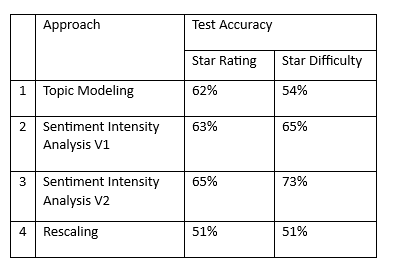

The dataset we used for this project is provided by the professor.
We have used the large dataset for training and small dataset for testing.


**What do we conclude ?**

> We have tried many approach and in almost all of them we got MSE of around 1.

>Sentiment Intensity Analysis V1 is a good approach but the V2 wins the race with text cleaning.

>Sentiment Intensity Analysis Version 2 performs the best with star rating of 65% and difficulty rating of 73%.

> Although we got validation accuracy of more that 84% in Approach 4, the testing accuracy is 51%. So, it seems this model is overfitted.

# Future Scope


**Approaches**


>Compare similarity based on a predetermined dataframe containing a collection of comments which are refined to achieve a maximum attaniable upper and lower bound for ratings and score.

for now we avoided this method as it was extremely demanding in terms of computational power due to its nature. we will work on finding an alternative to make it efficient. down is the code we tried :


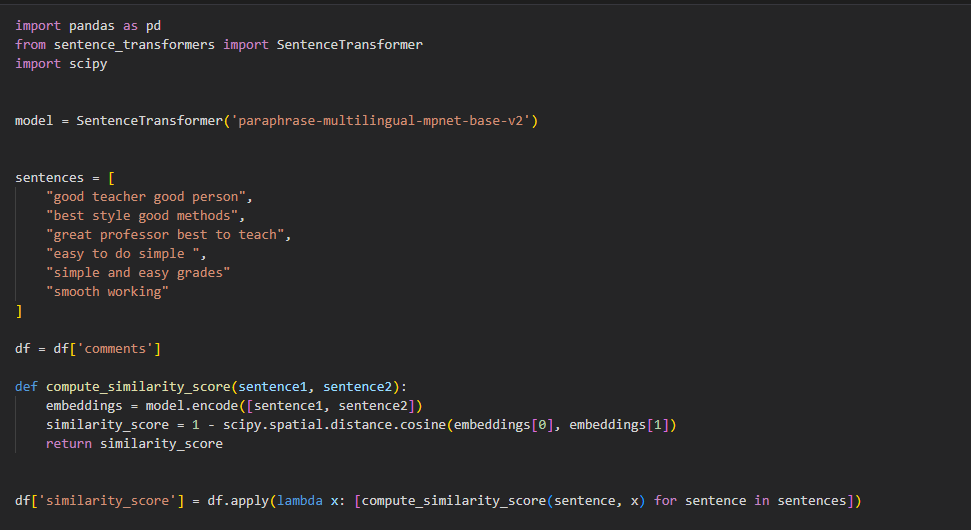

>Using GloVe along with embeddings trained on the student comments datasets. GloVe can capture general language patterns, while the other embeddings can capture patterns specific to the comments posted by the students.

>We read about ensemble learning which involves using the combination of predictions given by multiple models to use performance. Using this we can combine the models used by us to get a even more accurate prediction.

>WE could experiment with GRU layers as well, for now we decided to stick with LSTM since we achieved a satisfactory accuracy.